# IV Sweep
In this notebook, we perform an IV sweep by varying the current on the load across a range and observe the associated voltage and power delivered from the supply. Personally, I'm writing this to measure the IV characteristics of a solar panel but this could be used to make measurements on other supplies also.

## Initialisation
Instantiating the load and setting up the mode and maximum limits

In [1]:
from dcload import DCLoad
from matplotlib import pyplot as plt
import numpy as np
import time
import datetime

EMULATE = False # Use this flag to run with locally generated data and not the load

if not EMULATE:
    load = DCLoad("COM4", 9600, 0)  # Connecting to the load
    load.SetRemoteControl()  # Setting remote control
    load.TurnLoadOff()  # Making sure the load is off before setting up
    load.SetMode('cc')  # Setting CC mode
    load.SetMaxCurrent(10)  # Setting the maximum current
    load.SetMaxVoltage(100)   # Setting the maximum voltage
    load.SetMaxPower(300)  # Setting the maximum power
    load.SetCCCurrent(0)  # Setting the constant current setpoint
    load.SetLocalControl()  # Relinquishing remote control

## Running the sweep
Running the IV sweep and reporting the maximum power point found during the sweep. Set the start / stop currents and the step parameters here.

In [2]:
test_note = "Panel 3 - Shaded cell"
start_current = 0   # Amperes
stop_current  = 6   # Amperes
step_size     = 0.1 # Amperes
step_delay    = 0.5 # Seconds

start_time = time.time()
iter_points = np.arange(start=start_current, stop=stop_current+step_size, step=step_size)
timebase  = np.full(len(iter_points), np.nan)
curr_data = np.full(len(iter_points), np.nan)
volt_data = np.full(len(iter_points), np.nan)
powr_data = np.full(len(iter_points), np.nan)

if not EMULATE:
    load.SetRemoteControl()  # Setting remote control
    load.TurnLoadOn()  # Enabling the load

# Looping through and collecting the data
for idx, current in enumerate(iter_points):
    if EMULATE: # Making some fake data for the purpose of plotting
        timebase[idx]  = time.time() - start_time
        curr_data[idx] = current
        volt_data[idx] = 10-current*1.5
        powr_data[idx] = curr_data[idx]*volt_data[idx]
    else:
        load.SetCCCurrent(current)
        time.sleep(step_delay)
        load_data = load.GetInputValues()
        timebase[idx]  = time.time() - start_time
        curr_data[idx] = load_data['current']
        volt_data[idx] = load_data['voltage']
        powr_data[idx] = load_data['power']

# Calculating the index of the maximum power point and printing the V, I and P where the MPP was found.
mpp_idx = np.argmax(powr_data)
print("Maximum power point found: %.3fV, %.3fA, %.3fW" % (volt_data[mpp_idx], curr_data[mpp_idx], powr_data[mpp_idx]))

if not EMULATE:
    load.TurnLoadOff()  # Turning the load off
    load.SetLocalControl()  # Relinquishing remote control

Maximum power point found: 35.570V, 3.198A, 113.752W


## Plotting and saving the data
Plotting the IV curve, displaying the maximum power point and exporting the data with a timestamp and the test_note from above. Can't ever be too careful in taking notes when you're doing science! :)

<IPython.core.display.Javascript object>


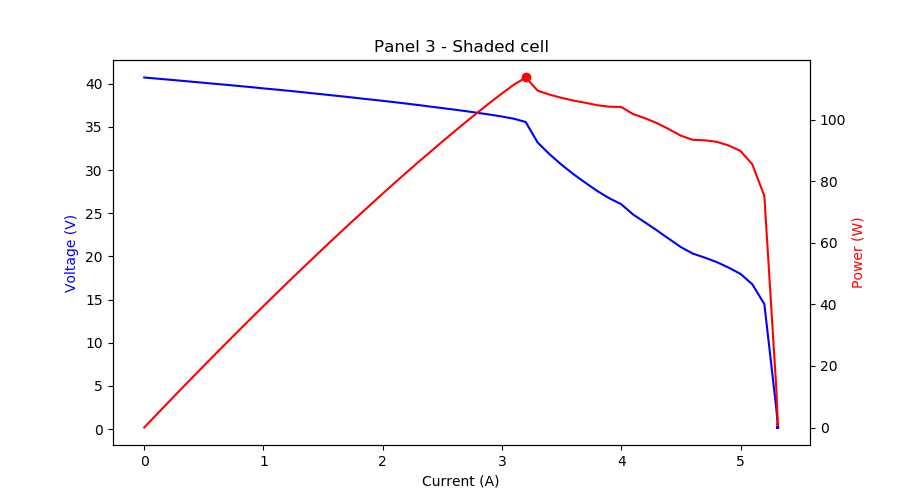

In [6]:
# Creating the plot
%matplotlib notebook
fig, ax1 = plt.subplots(figsize=(9, 5))
ax2 = ax1.twinx()
ax1.plot(curr_data, volt_data, 'b')
ax2.plot(curr_data, powr_data, 'r')
ax2.plot(curr_data[mpp_idx], powr_data[mpp_idx], 'ro') # Marking the max power point

# Annotating the plot
plt.title(test_note)
ax1.set_xlabel('Current (A)')
ax1.set_ylabel('Voltage (V)', color='b')
ax2.set_ylabel('Power (W)', color='r')
plt.show()

# Saving the data as a CSV with the timestamp in the filename if we're doing a real run.
if not EMULATE:
    now = datetime.datetime.now()
    datetime_string = now.strftime("%Y-%m-%d_%H-%M-%S_")
    np.savetxt(datetime_string + test_note + '.csv',
               np.transpose([timebase, curr_data, volt_data, powr_data]),
               delimiter=',',
               comments='',
               header='Timebase (s),Current (A),Voltage (V),Power (W)')